In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import torchvision.models as models

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'functions')))
from dataset import ChestXrayDataset
from train import train
from evaluation import plot_results ,eval_on_metrics
from gradcam import get_heatmap_for_resnet

In [2]:
IMAGE_PATH = "../archive/"
import glob

# Tüm alt klasörlerdeki jpg ve png dosyalarını alalım
image_paths = glob.glob(IMAGE_PATH + "**/images/*.[jp][pn]g", recursive=True)

print(f"Toplam {len(image_paths)} resim bulundu.")

Toplam 112120 resim bulundu.


In [3]:
TRAIN_PATH = '../data/AP_PA_Train.xlsx'
TEST_PATH = '../data/AP_PA_Test.xlsx'
VAL_PATH = '../data/AP_PA_Validation.xlsx'

In [4]:
num_classes = 2
EPOCHS = 30

In [5]:
model = models.resnet50(pretrained=True)

# Katmanların yarısını freeze yap
total_params = list(model.parameters())
half = len(total_params) // 2

for i, param in enumerate(total_params):
    if i < half:
        param.requires_grad = False  # İlk yarısını dondur
    else:
        param.requires_grad = True   # Kalan yarısını eğitilebilir bırak


in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# FC katmanını her zaman eğitilebilir bırak
for param in model.fc.parameters():
    param.requires_grad = True

c:\Users\Furkan-PC\192.168.0.14+8000\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Furkan-PC\192.168.0.14+8000\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(device)

cuda


In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:
train_dataset = ChestXrayDataset(TRAIN_PATH, image_paths,transform=transform)
val_dataset = ChestXrayDataset(TEST_PATH,image_paths, transform=transform)
test_dataset = ChestXrayDataset(VAL_PATH,image_paths, transform=transform)

In [9]:
print("Train size : ",len(train_dataset))
print("Validation size : ",len(val_dataset))
print("Test size : ",len(test_dataset))

Train size :  78566
Validation size :  16491
Test size :  17063


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True,num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True,num_workers=6)

In [11]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_dataloader, val_dataloader, criterion, optimizer, device,num_epochs=EPOCHS,patience=5)

Epoch 1/30 - Validation: 100%|██████████| 1031/1031 [01:12<00:00, 14.24it/s]


Epoch [1/30]
  Train Loss: 0.0365, Train Acc: 0.9917
  Val   Loss: 0.0310, Val   Acc: 0.9935
  Best model saved with val_loss: 0.0310


Epoch 2/30 - Validation: 100%|██████████| 1031/1031 [01:11<00:00, 14.52it/s]


Epoch [2/30]
  Train Loss: 0.0224, Train Acc: 0.9949
  Val   Loss: 0.0206, Val   Acc: 0.9956
  Best model saved with val_loss: 0.0206


Epoch 3/30 - Validation: 100%|██████████| 1031/1031 [01:20<00:00, 12.79it/s]


Epoch [3/30]
  Train Loss: 0.0181, Train Acc: 0.9957
  Val   Loss: 0.0220, Val   Acc: 0.9954
  No improvement. Early stopping counter: 1/5


Epoch 4/30 - Validation: 100%|██████████| 1031/1031 [01:10<00:00, 14.53it/s]


Epoch [4/30]
  Train Loss: 0.0147, Train Acc: 0.9964
  Val   Loss: 0.0231, Val   Acc: 0.9948
  No improvement. Early stopping counter: 2/5


Epoch 5/30 - Validation: 100%|██████████| 1031/1031 [01:18<00:00, 13.20it/s]


Epoch [5/30]
  Train Loss: 0.0111, Train Acc: 0.9969
  Val   Loss: 0.0232, Val   Acc: 0.9955
  No improvement. Early stopping counter: 3/5


Epoch 6/30 - Validation: 100%|██████████| 1031/1031 [01:16<00:00, 13.56it/s]


Epoch [6/30]
  Train Loss: 0.0081, Train Acc: 0.9975
  Val   Loss: 0.0238, Val   Acc: 0.9956
  No improvement. Early stopping counter: 4/5


Epoch 7/30 - Validation: 100%|██████████| 1031/1031 [01:11<00:00, 14.34it/s]

Epoch [7/30]
  Train Loss: 0.0059, Train Acc: 0.9982
  Val   Loss: 0.0313, Val   Acc: 0.9954
  No improvement. Early stopping counter: 5/5
  Early stopping triggered. Training stopped.


In [12]:
print(f"num_epochs: {EPOCHS}")
print(f"train_losses: {len(train_losses)}")
print(f"val_losses: {len(val_losses)}")
print(f"train_accuracies: {len(train_accuracies)}")
print(f"val_accuracies: {len(val_accuracies)}")


num_epochs: 30
train_losses: 7
val_losses: 7
train_accuracies: 7
val_accuracies: 7


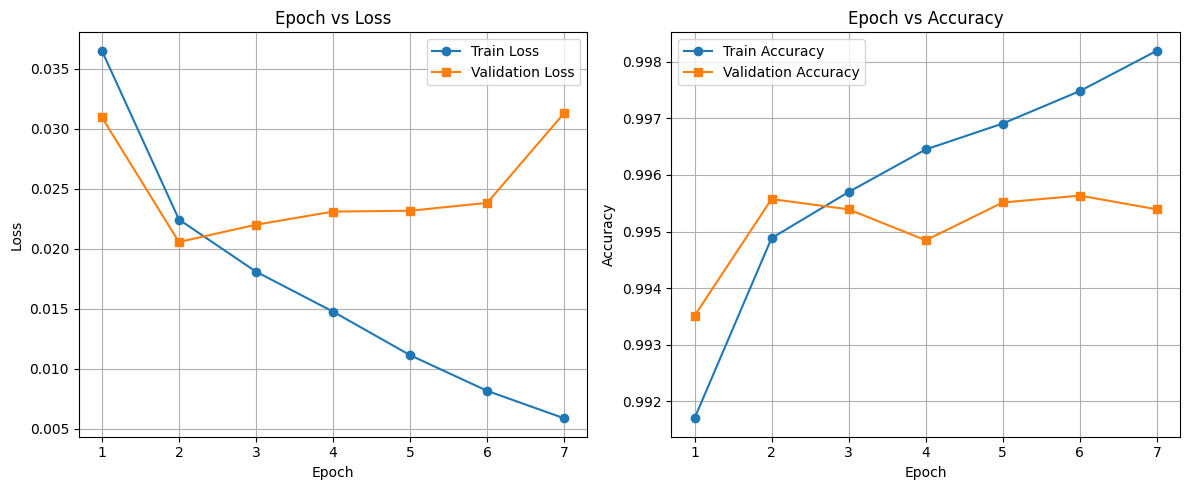

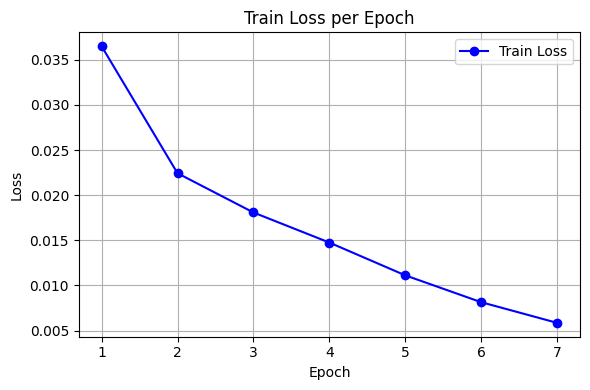

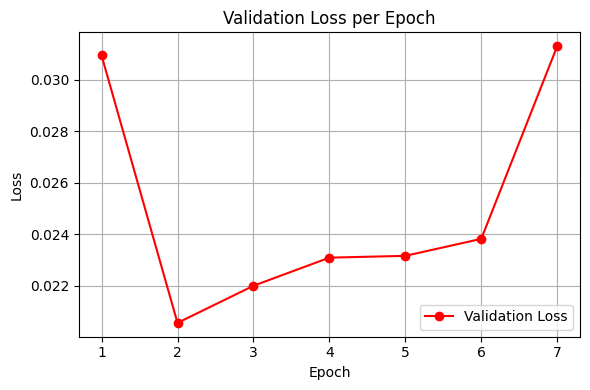

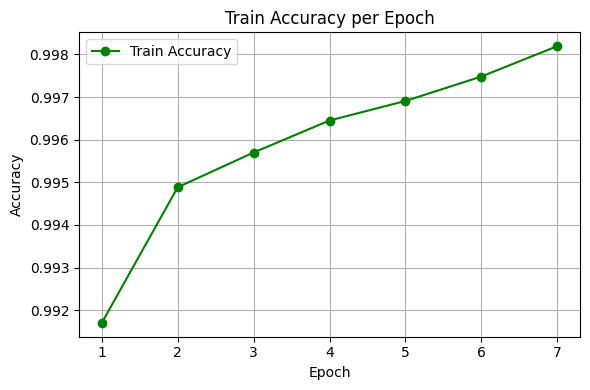

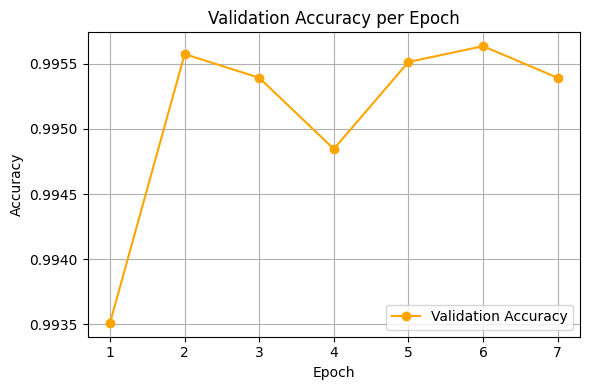

In [13]:
plot_results(train_losses, train_accuracies, val_losses, val_accuracies)

Evaluating: 100%|██████████| 1067/1067 [01:22<00:00, 12.93it/s]

Precision: 0.9944
Recall:    0.9983
F1 Score:  0.9964
AUC:       0.9994


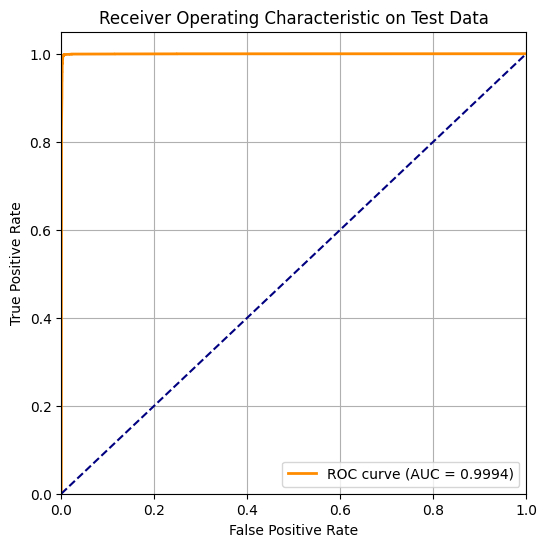

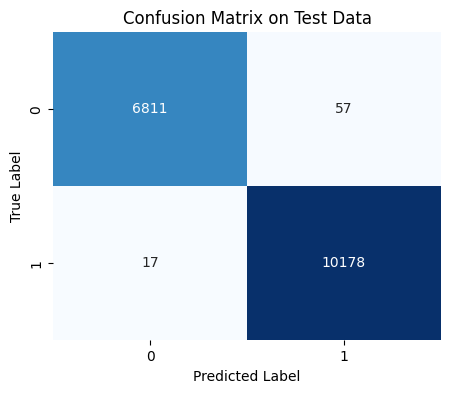

In [14]:
eval_on_metrics(model, test_dataloader)

In [15]:
test_dataset[0]

(tensor([[[-1.8953, -1.8953, -1.8953,  ..., -1.8953, -1.8953, -1.8953],
          [-1.9467, -1.9295, -1.9467,  ..., -1.9295, -1.9295, -1.9295],
          [-1.9809, -1.9638, -1.9809,  ..., -1.9809, -1.9809, -1.9809],
          ...,
          [-1.8268, -1.8268, -1.8097,  ..., -1.2788, -1.0904, -0.9534],
          [-1.8610, -1.8268, -1.8610,  ..., -1.3644, -1.2274, -1.0904],
          [-1.9124, -1.8953, -1.9124,  ..., -1.5870, -1.4843, -1.3644]],
 
         [[-1.8081, -1.8081, -1.8081,  ..., -1.8081, -1.8081, -1.8081],
          [-1.8606, -1.8431, -1.8606,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8957, -1.8782, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
          ...,
          [-1.7381, -1.7381, -1.7206,  ..., -1.1779, -0.9853, -0.8452],
          [-1.7731, -1.7381, -1.7731,  ..., -1.2654, -1.1253, -0.9853],
          [-1.8256, -1.8081, -1.8256,  ..., -1.4930, -1.3880, -1.2654]],
 
         [[-1.5779, -1.5779, -1.5779,  ..., -1.5779, -1.5779, -1.5779],
          [-1.6302, -1.6127,

In [16]:
model = models.resnet50(pretrained=True) 

# Son katmanı 2 sınıflı yap
model.fc = nn.Linear(model.fc.in_features, 2)

checkpoint_path = 'models/best_model.pth'
state_dict = torch.load(checkpoint_path)

# 3. state_dict'i modele yükle
model.load_state_dict(state_dict)

# 4. Modele eval modunu ver (inference için)
model.eval()

c:\Users\Furkan-PC\192.168.0.14+8000\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Furkan-PC\192.168.0.14+8000\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Furkan-PC\AppData\Local\Temp\ipykernel_2636\1396749602.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://gith

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
test_image_path = test_dataset.get_path(0)

c:\Users\Furkan-PC\192.168.0.14+8000\.venv\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


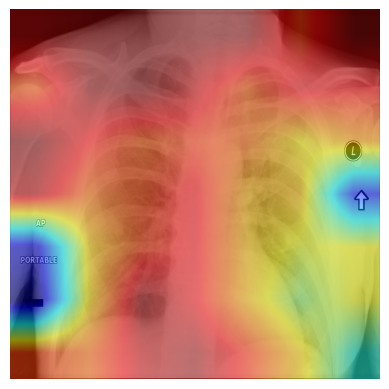

In [18]:
get_heatmap_for_resnet(model,test_image_path)